In [834]:
# load csv files in ../processed_ds/air_quality_cluster/site-x/site-x.csv where x is the site number
# and concatenate them into a single csv file by adding a column with the site number

import os
import pandas as pd
import numpy as np

#### Concat Sites

In [821]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Get the list of directories (sites)
files = os.listdir('../processed_ds/air_quality_cluster/')
files = [f for f in files if os.path.isdir('../processed_ds/air_quality_cluster/' + f)]
files.sort()  # Sort the site directories

# Initialize empty lists for train and test data
train_dfs = []
test_dfs = []

# Iterate over the site directories
for f in files:
    site_files = os.listdir(f'../processed_ds/air_quality_cluster/{f}')
    site_files = [sf for sf in site_files if sf.endswith('.csv')]
    site_files.sort()

    # Process each file in the site
    for sf in site_files:
        file_path = f'../processed_ds/air_quality_cluster/{f}/{sf}'
        df_site = pd.read_csv(file_path)

        # Add a site identifier column
        df_site['site'] = int(f.split('-')[1])

        # Perform 80-20 train-test split on time order
        train_size = int(0.8 * len(df_site))
        df_train = df_site.iloc[:train_size]  # First 80% as training data
        df_test = df_site.iloc[train_size:]  # Remaining 20% as test data

        # Append to lists
        train_dfs.append(df_train)
        test_dfs.append(df_test)

# Concatenate all train and test data separately
train_df = pd.concat(train_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)

# Save if needed
train_df.to_csv('../processed_ds/air_quality_cluster/train_data.csv', index=False)
test_df.to_csv('../processed_ds/air_quality_cluster/test_data.csv', index=False)

# Print summary
print(f"Total Train Samples: {len(train_df)}")
print(f"Total Test Samples: {len(test_df)}")

Total Train Samples: 336612
Total Test Samples: 84156


In [973]:
# load the dataframe
train_df = pd.read_csv('../processed_ds/air_quality_cluster/train_data.csv')
test_df = pd.read_csv('../processed_ds/air_quality_cluster/test_data.csv')

# move the site column to the 2nd position
# cols = list(df.columns)
# cols = cols[:1] + cols[-1:] + cols[1:-1]
# df = df[cols]

In [974]:
train_df = train_df.drop(columns=['date'])
test_df = test_df.drop(columns=['date'])


#### SIMPLE SINE WAVE TEST


In [662]:
def generate_sine_data(seq_length=32, horizon=16, num_samples=1000):
    x = np.linspace(0, 100, num_samples)  # Create time steps
    y = np.sin(x)  # Sine function
    X, Y = [], []
    for i in range(len(y) - seq_length - horizon + 1):  # Avoid out-of-bounds
        X.append(y[i:i + seq_length])  # Input sequence
        Y.append(y[i + seq_length:i + seq_length + horizon])  # Predict next 16 steps

    return np.array(X), np.array(Y), y

SEQ_LEN = 32  # Input window length
HORIZON = 16  # Predict one step ahead

X, y, oop = generate_sine_data(seq_length=SEQ_LEN)

#### Real Data

In [975]:
train_df = (train_df - train_df.mean()) / (train_df.std() + 1e-8)
test_df = (test_df - test_df.mean()) / (test_df.std() + 1e-8)
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# df = scaler.fit_transform(df)

# df = pd.DataFrame(df)

#### Site wise processing

In [932]:
df = pd.read_csv("../processed_ds/air_quality_cluster/site-6/site-6.csv")
df.drop(columns=['date'], inplace = True)
# Perform an 80-20 split based on time
train_size = int(0.8 * len(df))

train_df = df.iloc[:train_size]  # First 80% for training
test_df = df.iloc[train_size:]   # Last 20% for testing (future data)

In [933]:
train_df = (train_df - train_df.mean()) / (train_df.std() + 1e-8)
test_df = (test_df - test_df.mean()) / (test_df.std() + 1e-8)

#### Model Setup

In [976]:
def df_to_X_y(df, target_col=10, window_size=32, horizon=2):
    df_as_np = df.to_numpy()
    X, y = [], []

    for i in range(len(df_as_np) - window_size - horizon + 1):  # Adjust to avoid out-of-bounds
        # Select past 'window_size' rows as features
        X.append(df_as_np[i:i + window_size])

        # Select the next 'horizon' future values for target column
        y.append(df_as_np[i + window_size:i + window_size + horizon, target_col])  

    return np.array(X), np.array(y)

In [977]:
# Process Train Data
X_train, y_train = df_to_X_y(train_df, target_col=9)  # Use correct target column

# Process Test Data
X_test, y_test = df_to_X_y(test_df, target_col=9)  # Same column index

In [978]:
X_train.shape

(336579, 32, 12)

In [979]:
y_train.shape

(336579, 2)

In [982]:
# pytorch LSTM MODEL with 2 lstm layers two linear layers, 30 epochs, 0.01 learning rate, output window size 16, hidden layer size 16
# self.fc1 = nn.Linear(hidden_size * time_window, num_features * time_window)
        # self.fc2 = nn.Linear(num_features * time_window, num_labels * output_window)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


class LSTMForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(LSTMForecaster, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Predict 'horizon' steps
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # (batch, seq_length, hidden_dim)
        last_hidden = lstm_out[:, -1, :]  # Take last time step's hidden state
        return self.fc(last_hidden.reshape(16, -1))  # Output (batch, horizon)

class LSTMModel(nn.Module):
    def __init__(self,
                 num_tasks,
                 num_features,
                 time_window,
                 output_window,
                 num_labels,
                 num_layers=2,
                 hidden_size=16):
        super(LSTMModel, self).__init__()

        self.output_window = output_window
        self.num_labels = num_labels
        self.dual = False

        self.intermediary = False

        self.lstm = nn.LSTM(num_features,
                            hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=0.2)
        self.fc = nn.Linear(hidden_size, num_labels * output_window)
        # self.fc1 = nn.Linear(hidden_size * time_window, num_features * time_window)
        # self.fc2 = nn.Linear(num_features * time_window, num_labels * output_window)

    def forward(self, x):
        B, T, D = x.shape  # Fix: Remove x[0], should be x
        # h0 = torch.zeros(2, B, 16).to(x.device)
        # c0 = torch.zeros(2, B, 16).to(x.device)
        # x_, _ = self.lstm(x)
        # x_ = self.fc1(x_.reshape(B, -1))
        # x_ = self.fc2(x_)
        # x_ = x_.reshape(B, self.output_window, self.num_labels)
        x_, _ = self.lstm(x)
        # Select the last time step's hidden state (most recent information)
        last_hidden = x_[:, -1, :]  # Shape: (B, hidden_size)

        # Fully connected layer
        x_ = self.fc(last_hidden)  # Shape: (B, num_labels * output_window)

        # Reshape to (B, output_window, num_labels)
        x_ = x_.reshape(B, self.output_window, self.num_labels)
        return x_



In [988]:
# Hyperparameters
SEQ_LEN = 32  # Input window length
HORIZON = 2  # Prediction horizon
NUM_FEATURES = 12 # Input features (e.g., PM2.5, NO2)
NUM_LABELS = 1  # Predict same number of labels

# Instantiate model
model = LSTMModel(
    num_tasks=1,  # Only 1 task
    num_features=NUM_FEATURES,
    time_window=SEQ_LEN,
    output_window=HORIZON,
    num_labels=NUM_LABELS,
    num_layers=2,
    hidden_size=16 # Increased hidden size
)
model.to("cuda")

model2 = LSTMForecaster(
    input_dim = NUM_FEATURES,  # Number of features
    hidden_dim = 16,
    num_layers = 2,
    output_dim = 16,  # Forecast 16 steps aheah
)
model2.to("cuda")

LSTMForecaster(
  (lstm): LSTM(12, 16, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=16, out_features=16, bias=True)
)

In [989]:
def train_model(model, train_loader, num_epochs=20, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    device = "cuda"

    for epoch in range(num_epochs):
        print("EPOCH: ", epoch)
        model.train(True)
        running_loss = 0.0
        
        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            output = model(x_batch)
            y_batch = y_batch.unsqueeze(-1)
            loss = criterion(output, y_batch)
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

In [990]:
# Convert to PyTorch tensors
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)


In [991]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to('cpu'), batch[1].to('cpu')
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 32, 12]) torch.Size([16, 2])


In [992]:
train_model(model, train_loader, num_epochs=30, lr=1e-3)

EPOCH:  0
Epoch 1, Loss: 0.4152
EPOCH:  1
Epoch 2, Loss: 0.3941
EPOCH:  2
Epoch 3, Loss: 0.3892
EPOCH:  3
Epoch 4, Loss: 0.3858
EPOCH:  4
Epoch 5, Loss: 0.3830
EPOCH:  5
Epoch 6, Loss: 0.3808
EPOCH:  6
Epoch 7, Loss: 0.3790
EPOCH:  7
Epoch 8, Loss: 0.3772
EPOCH:  8
Epoch 9, Loss: 0.3752
EPOCH:  9
Epoch 10, Loss: 0.3735
EPOCH:  10
Epoch 11, Loss: 0.3722
EPOCH:  11
Epoch 12, Loss: 0.3714
EPOCH:  12
Epoch 13, Loss: 0.3703
EPOCH:  13
Epoch 14, Loss: 0.3690
EPOCH:  14
Epoch 15, Loss: 0.3684
EPOCH:  15
Epoch 16, Loss: 0.3673
EPOCH:  16
Epoch 17, Loss: 0.3670
EPOCH:  17
Epoch 18, Loss: 0.3662
EPOCH:  18
Epoch 19, Loss: 0.3655
EPOCH:  19
Epoch 20, Loss: 0.3656
EPOCH:  20
Epoch 21, Loss: 0.3647
EPOCH:  21
Epoch 22, Loss: 0.3645
EPOCH:  22
Epoch 23, Loss: 0.3635
EPOCH:  23
Epoch 24, Loss: 0.3628
EPOCH:  24
Epoch 25, Loss: 0.3633
EPOCH:  25
Epoch 26, Loss: 0.3622
EPOCH:  26
Epoch 27, Loss: 0.3624
EPOCH:  27
Epoch 28, Loss: 0.3618
EPOCH:  28
Epoch 29, Loss: 0.3615
EPOCH:  29
Epoch 30, Loss: 0.3611

In [993]:
def evaluate_model(model, test_loader):
    model.eval()
    mae_list = []
    criterion = nn.L1Loss()
    
    all_predictions = []
    all_actuals = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")
    
            predictions = model(batch_x)
          
            # Compute MAE for each horizon step
            mae = criterion(predictions, batch_y.unsqueeze(-1)).item()
            mae_list.append(mae)
            
            # Move tensors to CPU and convert to numpy for plotting
            all_predictions.append(predictions.cpu().numpy())
            all_actuals.append(batch_y.cpu().numpy())
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_actuals = np.concatenate(all_actuals, axis=0)

    return np.mean(mae_list), all_predictions, all_actuals  # Average MAE across batches

mae, predictions, actuals = evaluate_model(model, test_loader)
print(f"Mean Absolute Error (MAE) across horizon: {mae:.4f}")

Mean Absolute Error (MAE) across horizon: 0.4594


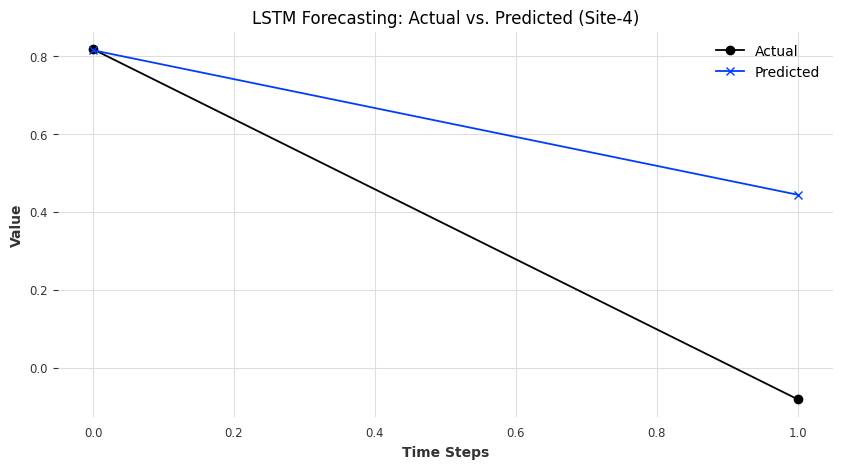

In [996]:
def plot_predictions(actuals, predictions, sample_idx=0, horizon=16):
    plt.figure(figsize=(10, 5))
    
    actual = actuals[sample_idx]  # Shape (horizon,)
    pred = predictions[sample_idx]  # Shape (horizon,)

    # Plot actual values
    plt.plot(range(len(actual)), actual, label="Actual", marker="o")

    # Plot predicted values
    plt.plot(range(len(pred)), pred, label="Predicted", marker="x")

    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.title("LSTM Forecasting: Actual vs. Predicted (Site-4)")
    plt.legend()
    plt.show()

# Plot for first sample in test set
plot_predictions(actuals, predictions, sample_idx=1, horizon=HORIZON)

In [583]:
predictions.shape

(176, 1)

In [584]:
actuals.shape

(176, 16, 1)

In [ ]:
# Data Preprocessing
